# Mount your drive (in case you want to save some results) + GitHub directory
* Please use GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Git
!git clone https://github.com/Hesam-92-19/Transfer_Learning_SHM



# Download + Unzip data files

In [5]:
# Download the Benchmarks and required data as ZIP files 
import shutil
from zipfile import ZipFile
import urllib
AD1='https://drive.google.com/uc?export=download&id=1-422on4tCy7EbCvKLdMboy9y_X0d703E&confirm=t&uuid=b1f020cb-df7a-46fb-ad9f-0de7c901dc97&at=ALgDtsxV0uvcfl6acmBvQTEYcQGW:1678645176383'
AD2='https://drive.google.com/uc?export=download&id=1XeU0hfYAvIR6woDqRp1EGt-4YdQmAIFW&confirm=t&uuid=b1f020cb-df7a-46fb-ad9f-0de7c901dc97&at=ALgDtsxV0uvcfl6acmBvQTEYcQGW:1678645176383'
urllib.request.urlretrieve(AD1, 'A.zip')
urllib.request.urlretrieve(AD2, 'B.zip')

## Extracting the ZIP files
with ZipFile('A.zip', 'r') as f:
  f.extractall('Detectors')
with ZipFile('B.zip', 'r') as f:
  f.extractall('Dataset')

import os
os.remove('A.zip')
os.remove('B.zip')

# Utils Notebook which is called in this cell contains all the functions needed to carry out the TL.

In [8]:
import sys
Folder_N='Test'
path_M = "/content/"
sys.path.append(path_M)
%cd /content/Transfer_Learning_SHM
%run Utils.ipynb
%cd

/content/Transfer_Learning_SHM
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/root


# Loss functions

In [9]:
def discriminator_loss(logits_real, logits_fake):
    C=0.00000000000000000000000000001
    true_labels = torch.ones(logits_real.size(),device=device)
    loss =-1*torch.mean(torch.log10(logits_real+C)+torch.log10(1-logits_fake+C))
    return loss

def generator_loss(logits_fake):
    C=0.00000000000000000000000000001
    true_labels = torch.ones(logits_fake.size(),device=device)
    loss=-1*torch.mean(torch.log10(logits_fake+C))
    return loss

# Load Yellow Frame
$W$=1000, $N$=10
* W is the data signal length, N is the number of sensors

A sample data instance feature


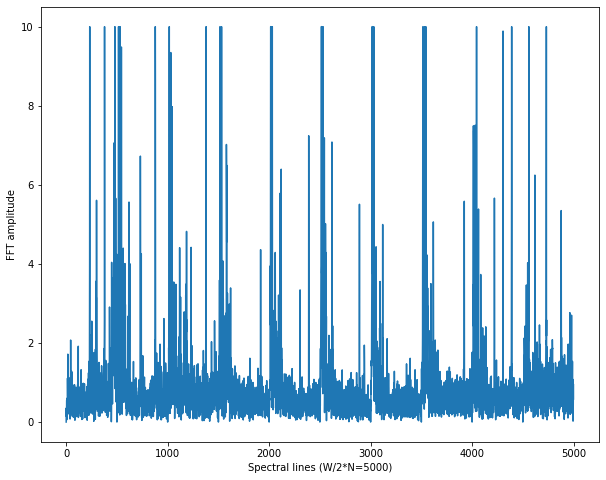

In [10]:
# Yellow Frame has 21 data classes
CL=21
W=1000
N=10
path_D=os.path.join(path_M+'Dataset/Yellow_'+'S'+str(N)+'_'+str(W)+'.mat')
path_Z=os.path.join(path_M+'Dataset/Yellow_Classes_'+str(W)+'.mat')
data_dict_D = mat73.loadmat(path_D)
data_dict_Z = mat73.loadmat(path_Z)

# Data class length
Data_CL=np.array(data_dict_Z["Zet"])[0:CL]
Data_CL=np.concatenate(([0],Data_CL))
E1=np.cumsum(Data_CL)
# Dataset including FFT features
DM=np.array(data_dict_D["C"][0:int(E1[CL]),:])

print('A sample data instance feature')
plt.plot(DM[0,:])
plt.xlabel('Spectral lines (W/2*N=5000)');
plt.ylabel('FFT amplitude');

#GAN Training function 
* show_every dictates the plotting interval

In [11]:
# Sampling from latent space function
def sample_noise(batch_size, dim):
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)
def GAN_train(E1,N,W,CL,DM,D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=10,batch_size=100, noise_size=100, num_epochs=30, train_loader=None, device=None):
     G_Loss=np.array([])
     G_Loss1=np.array([])   
     iter_count=1
     S=N
     for epoch in range(num_epochs):
        real_images = np.reshape(train_loader.detach().cpu().numpy(),(train_loader.shape[0],1,S*(int(W/2))))
        real_images=torch.Tensor(real_images).to(device)
        d_error = None
        g_error = None
        G_generated = None
        D_solver.zero_grad()

        # Sampling from the latent space
        random_noise = sample_noise(batch_size, noise_size).to(device)
        random_noise = random_noise/torch.max(random_noise)
        G_generated = G(random_noise)

# D loop
        disc_fake = D.forward(G_generated.reshape(batch_size,1,S*int(W/2)))
        D_Train = D(real_images)
        d_error = discriminator_loss(D_Train, disc_fake)
        G_Loss1=np.append(G_Loss1,d_error.detach().cpu().numpy())
        d_error.backward()
        D_solver.step()

# G loop
        G_solver.zero_grad()
        random_noise = torch.randn((batch_size, noise_size), device=device)
        random_noise = random_noise/torch.max(random_noise)
        G_generated = G(random_noise)
        disc_fake = D.forward(G_generated.reshape(batch_size,1,S*int(W/2)))
        g_error = generator_loss(disc_fake)
        G_Loss=np.append(G_Loss,g_error.detach().cpu().numpy())
        g_error.backward()
        G_solver.step()
        D_initiation=np.array([E1,np.zeros((CL+1))])
        
## Depict $S$ for all the dataset
        if (iter_count % show_every == 1):
            print('Iter: {}, D_Loss: {:.4}, G_Loss:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
            MM=G_generated.detach().cpu()
            A=D(torch.Tensor(DM.reshape(int(DM.shape[0]),1,S*int(W/2))))
            plt.plot(-torch.log10(A).detach().cpu().numpy())
            plt.plot(D_initiation[0,::],D_initiation[1,:], 'ro', markersize=12)
            plt.ylabel('$S$',fontsize=20)
            plt.xlabel('Data instance',fontsize=20)
            plt.legend(['Data','Damage instantiation'],fontsize=20)
            plt.show()
        iter_count += 1
     return G_Loss,G_Loss1



# GAN training
* It plots $S$ (novelty detection score) vs Iteration number, as shown in the manuscript Fig. 11
* Change Show-every variable to change plot intervals
* Batch size is set equal to the tarining size, so each iteration = one epoch

Iter: 1, D_Loss: 0.6086, G_Loss:0.2944


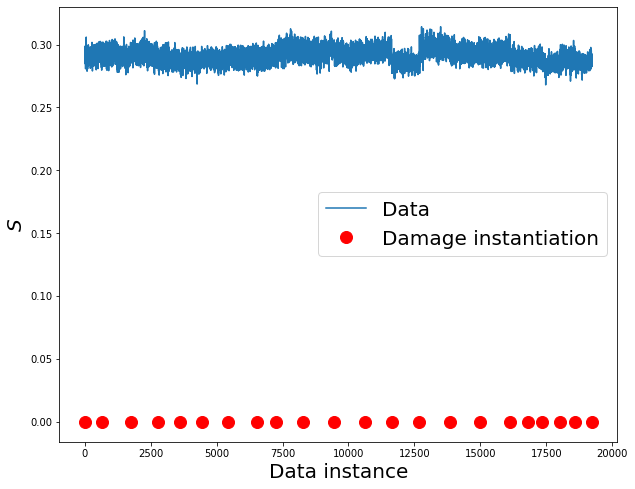

Iter: 51, D_Loss: 0.4722, G_Loss:0.26


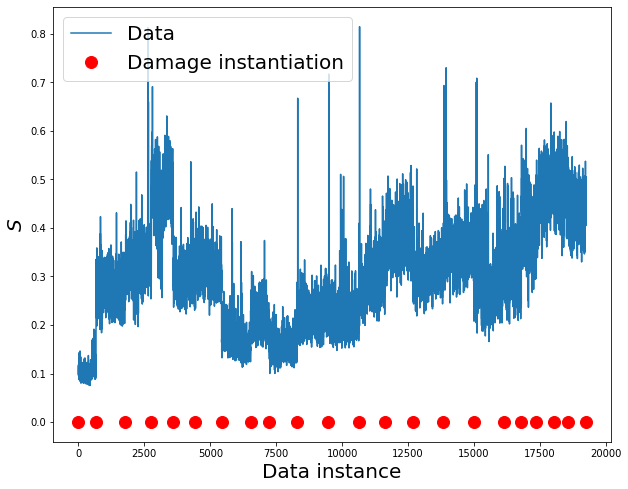

Iter: 101, D_Loss: 0.3985, G_Loss:0.3551


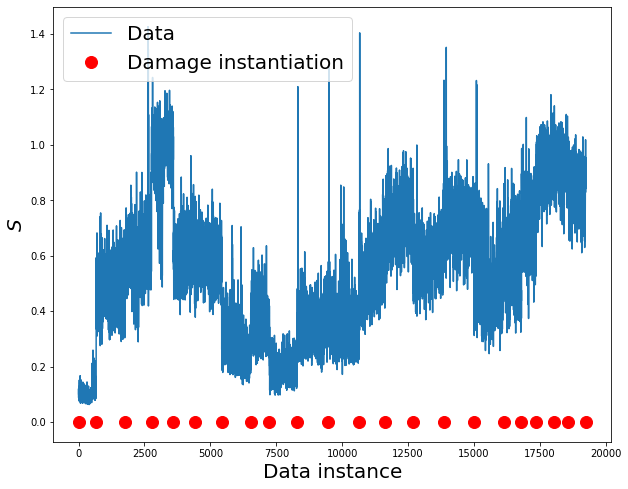

Iter: 151, D_Loss: 0.2564, G_Loss:0.5962


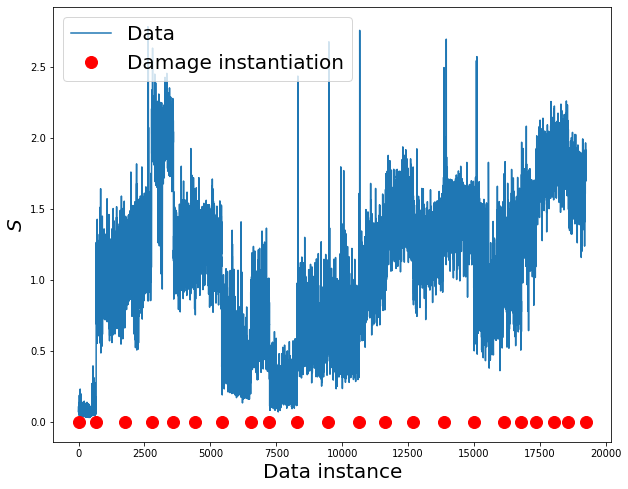

Iter: 201, D_Loss: 0.1036, G_Loss:1.046


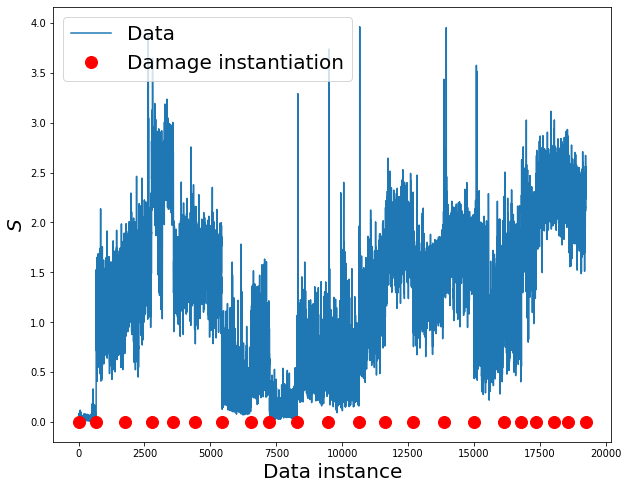

Iter: 251, D_Loss: 0.07116, G_Loss:1.404


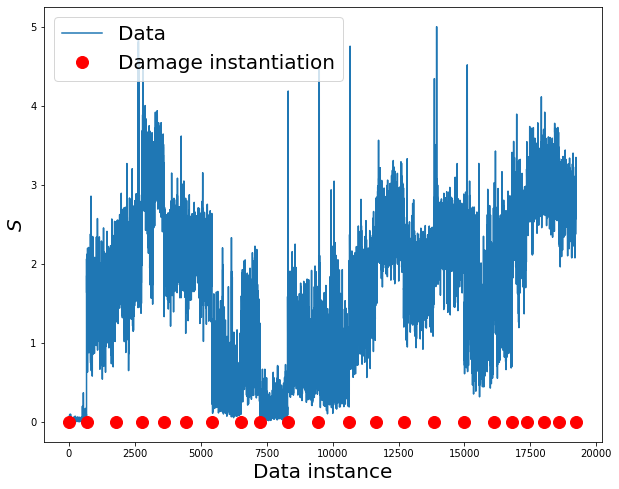

Iter: 301, D_Loss: 0.1267, G_Loss:1.322


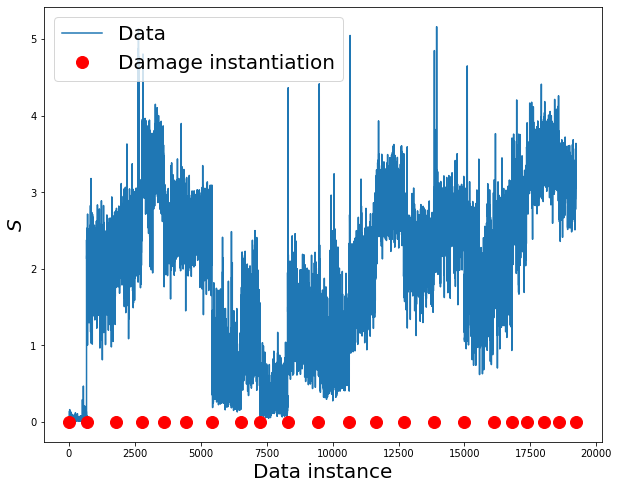

Iter: 351, D_Loss: 0.1981, G_Loss:0.9746


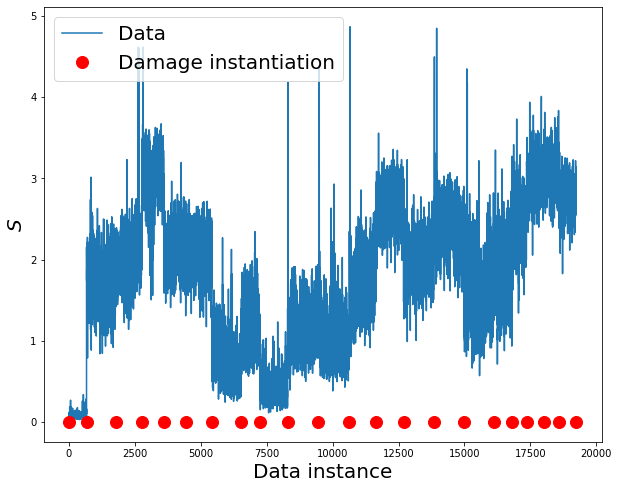

Iter: 401, D_Loss: 0.2082, G_Loss:0.9912


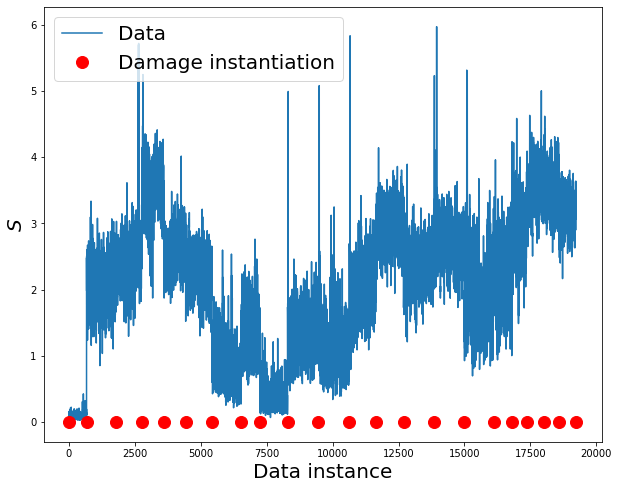

Iter: 451, D_Loss: 0.1886, G_Loss:1.096


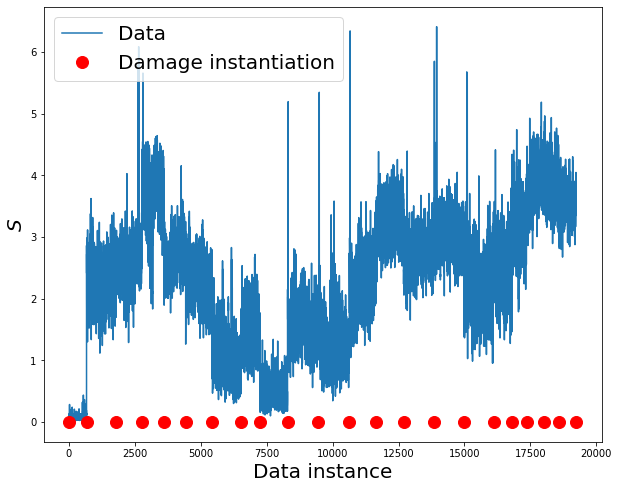

Iter: 501, D_Loss: 0.1647, G_Loss:1.125


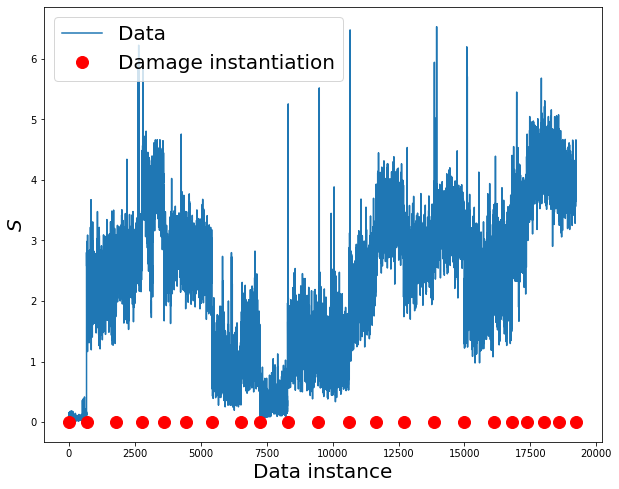

Iter: 551, D_Loss: 0.2173, G_Loss:1.059


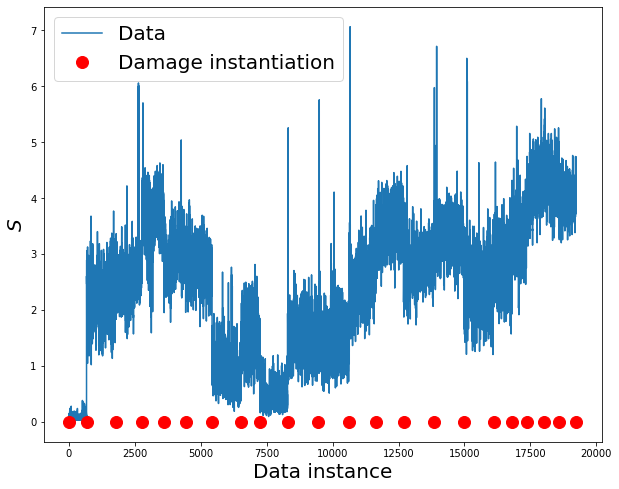

Iter: 601, D_Loss: 0.2128, G_Loss:1.145


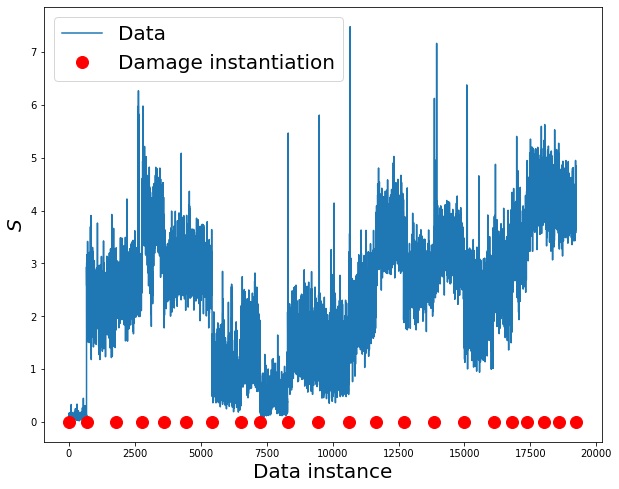

Iter: 651, D_Loss: 0.2148, G_Loss:1.098


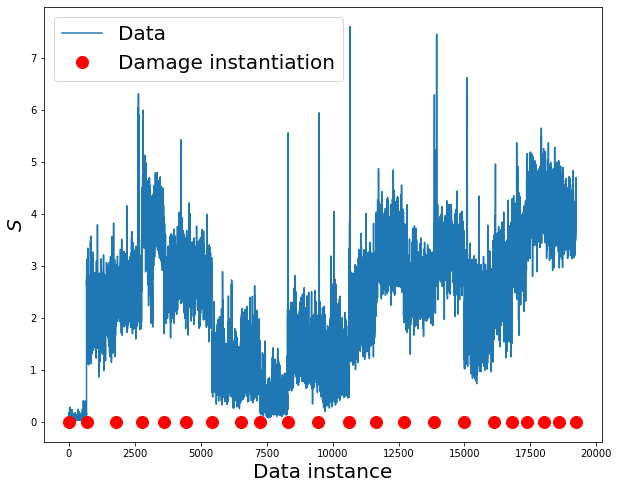

Iter: 701, D_Loss: 0.2165, G_Loss:1.123


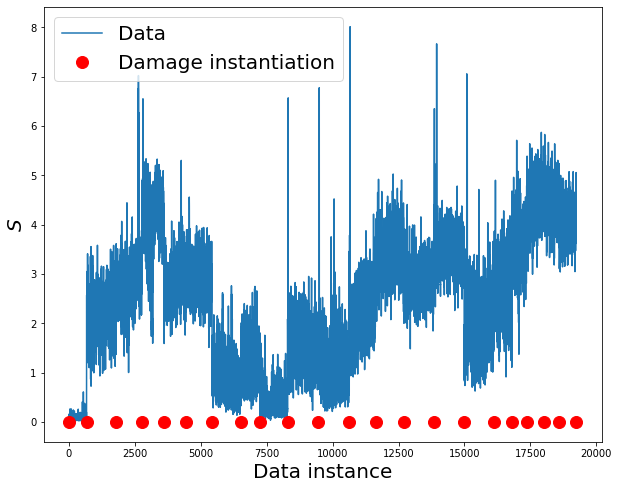

Iter: 751, D_Loss: 0.1952, G_Loss:1.181


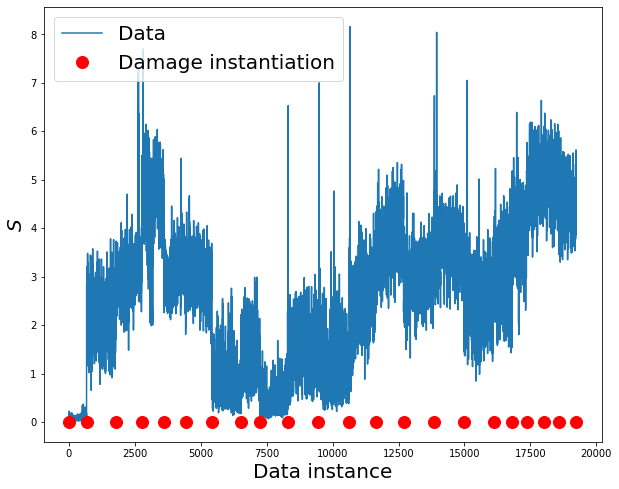

Iter: 801, D_Loss: 0.2021, G_Loss:1.188


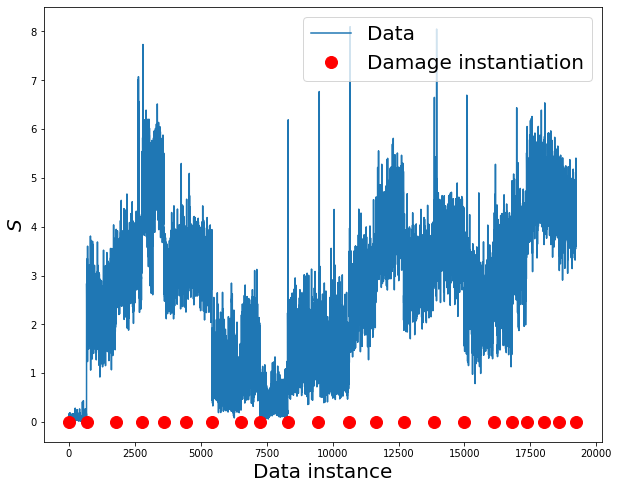

Iter: 851, D_Loss: 0.2137, G_Loss:1.195


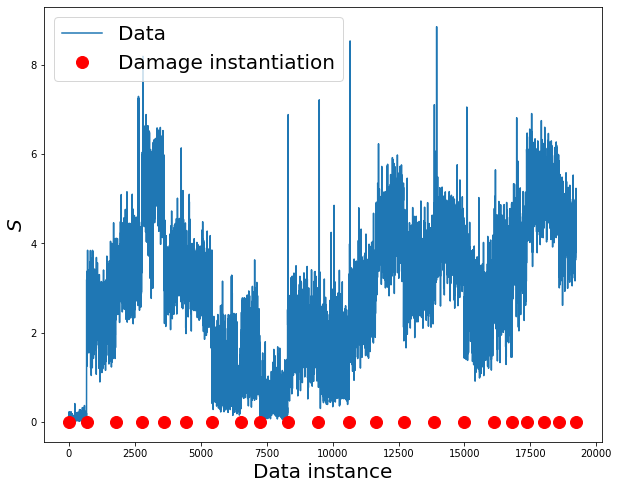

Iter: 901, D_Loss: 0.1593, G_Loss:1.212


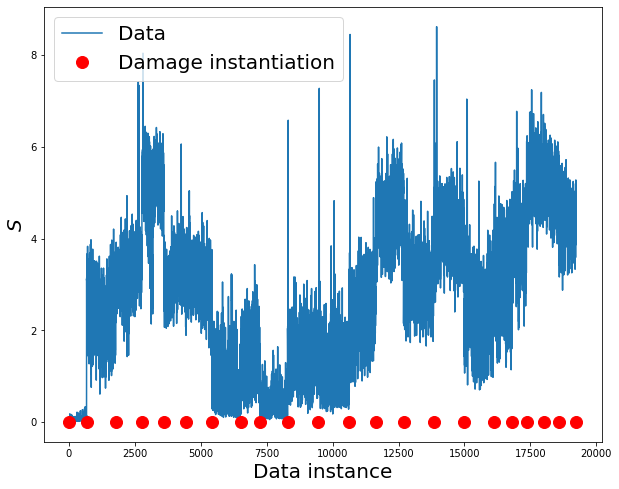

Iter: 951, D_Loss: 0.1657, G_Loss:1.299


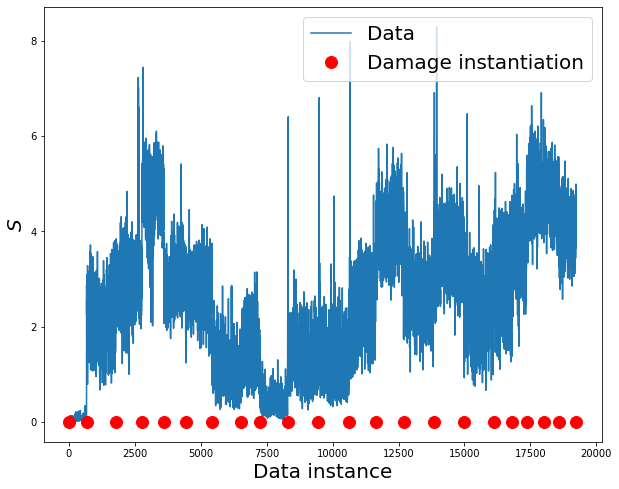

Iter: 1001, D_Loss: 0.2035, G_Loss:1.207


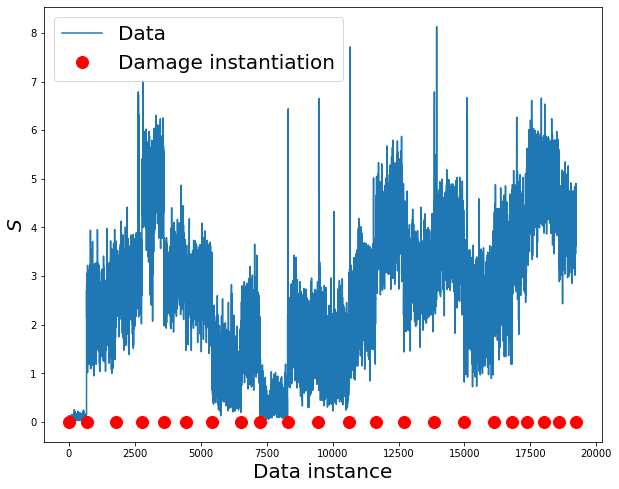

Iter: 1051, D_Loss: 0.2055, G_Loss:1.217


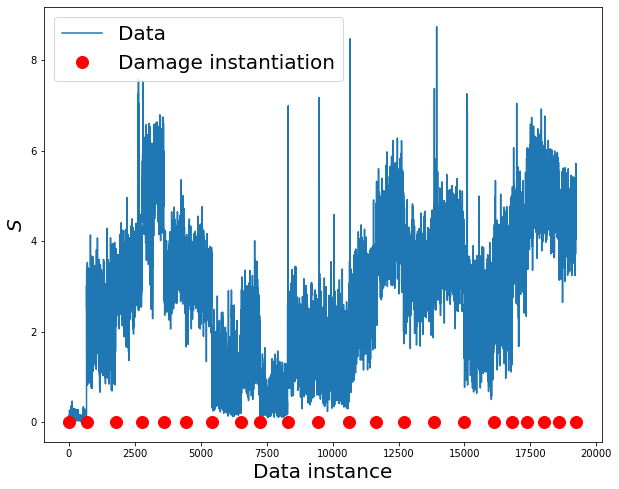

Iter: 1101, D_Loss: 0.2525, G_Loss:1.129


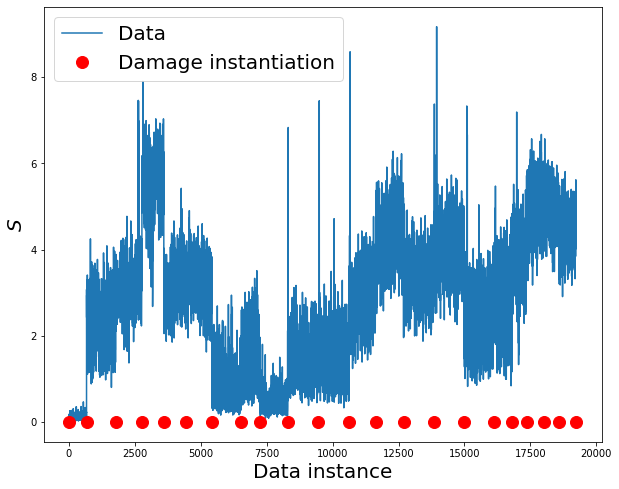

Iter: 1151, D_Loss: 0.1855, G_Loss:1.163


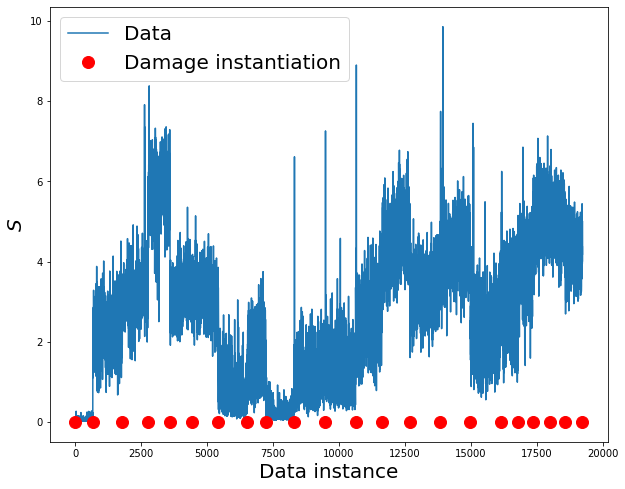

Iter: 1201, D_Loss: 0.1794, G_Loss:1.188


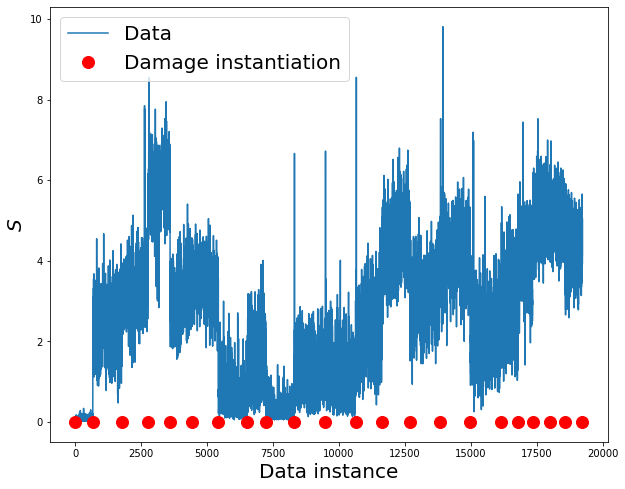

Iter: 1251, D_Loss: 0.1605, G_Loss:1.207


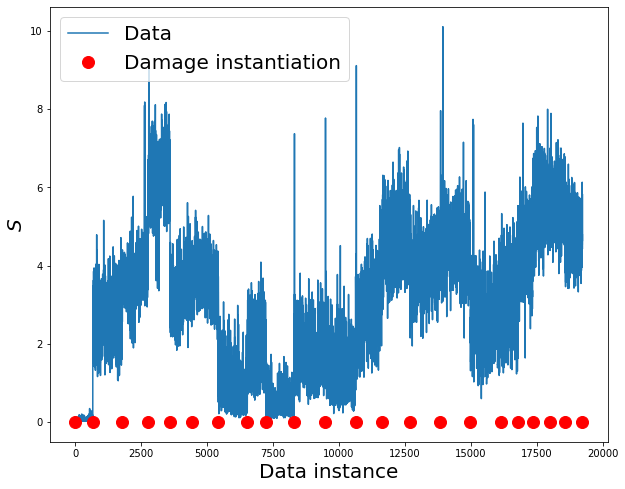

Iter: 1301, D_Loss: 0.2554, G_Loss:1.151


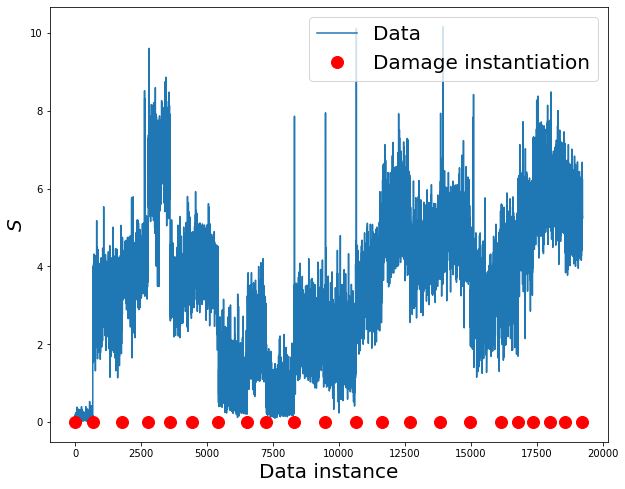

Iter: 1351, D_Loss: 0.1644, G_Loss:1.242


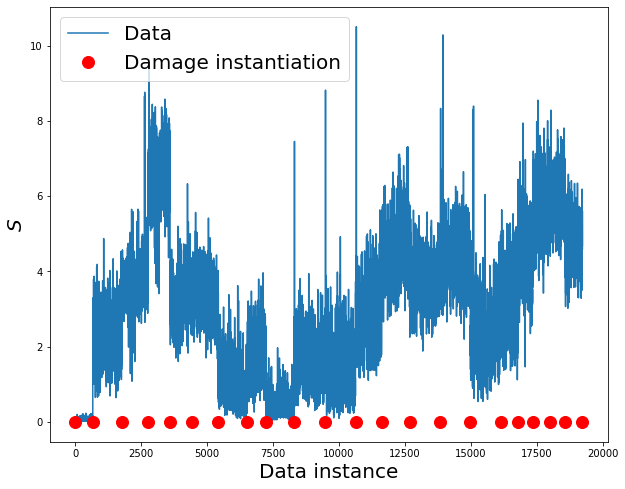

Iter: 1401, D_Loss: 0.167, G_Loss:1.166


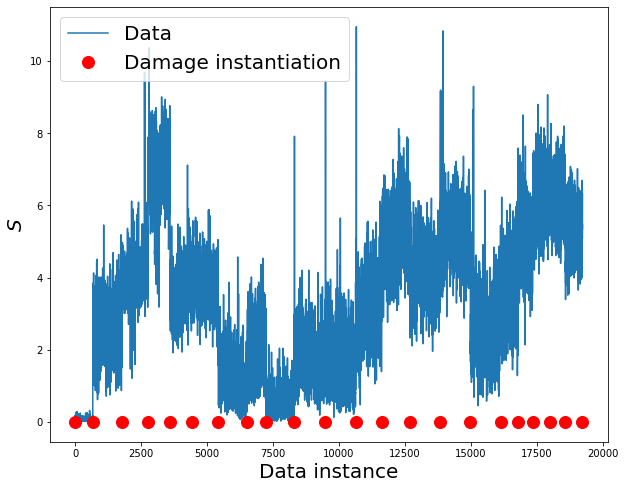

Iter: 1451, D_Loss: 0.1646, G_Loss:1.254


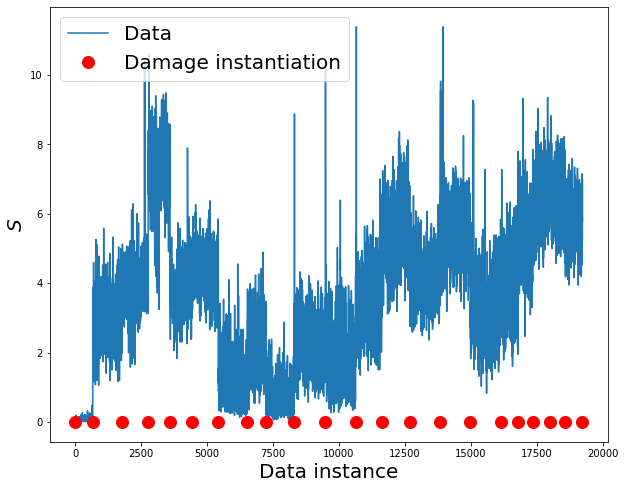

Iter: 1501, D_Loss: 0.1655, G_Loss:1.224


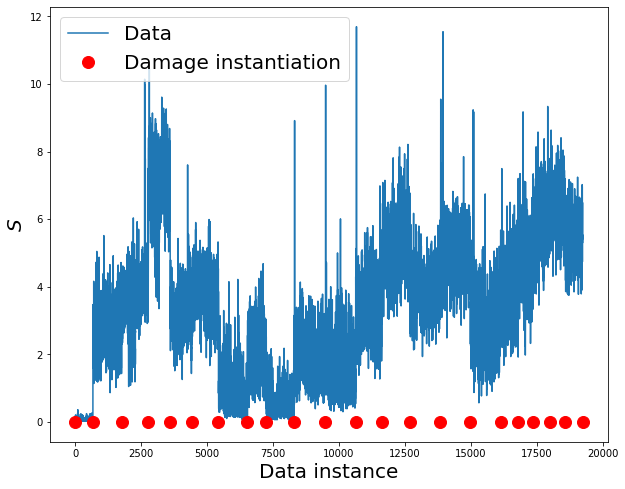

Iter: 1551, D_Loss: 0.1492, G_Loss:1.279


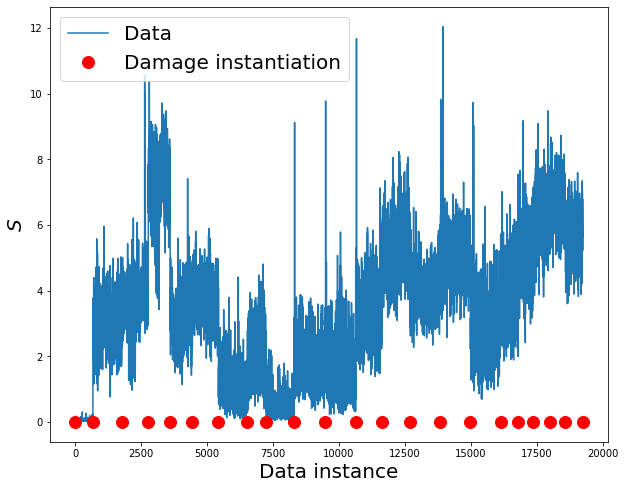

Iter: 1601, D_Loss: 0.1839, G_Loss:1.317


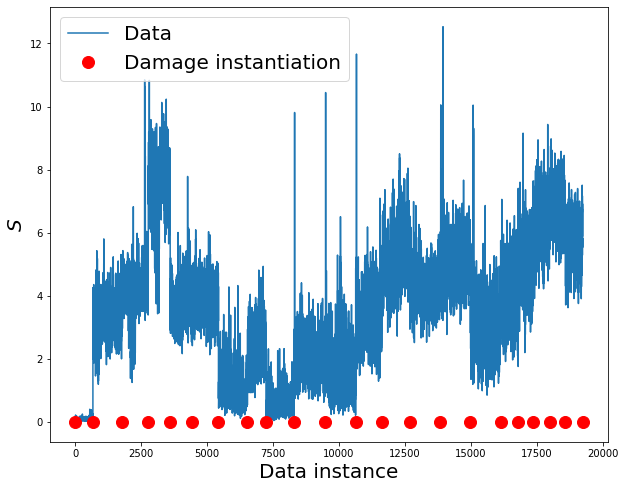

Iter: 1651, D_Loss: 0.1495, G_Loss:1.276


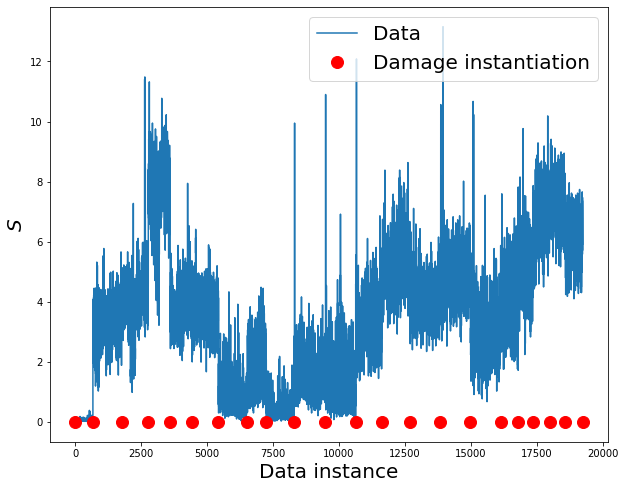

Iter: 1701, D_Loss: 0.182, G_Loss:1.301


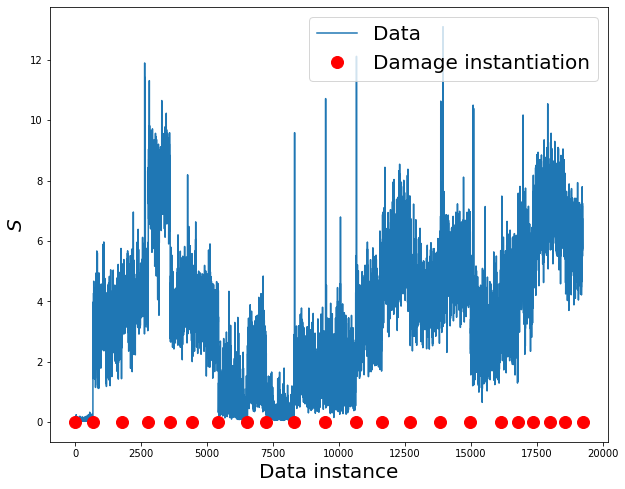

Iter: 1751, D_Loss: 0.1561, G_Loss:1.372


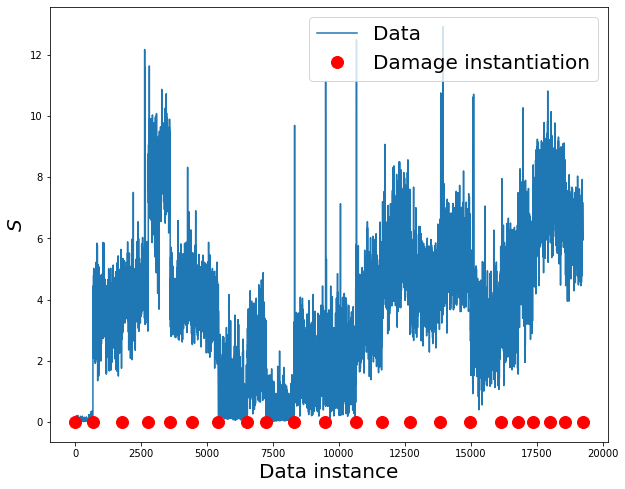

Iter: 1801, D_Loss: 0.1059, G_Loss:1.401


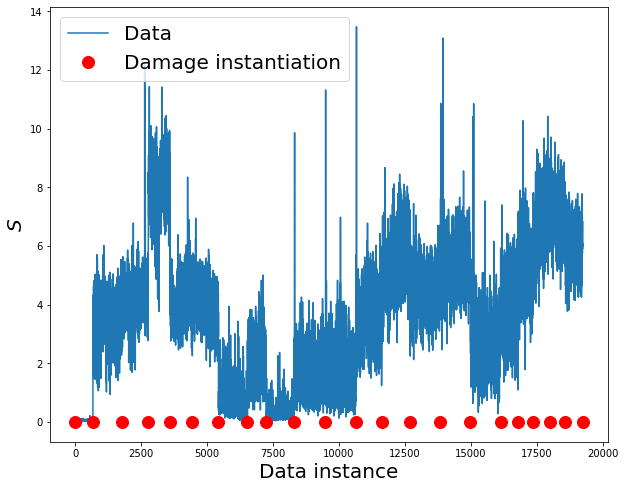

Iter: 1851, D_Loss: 0.1262, G_Loss:1.268


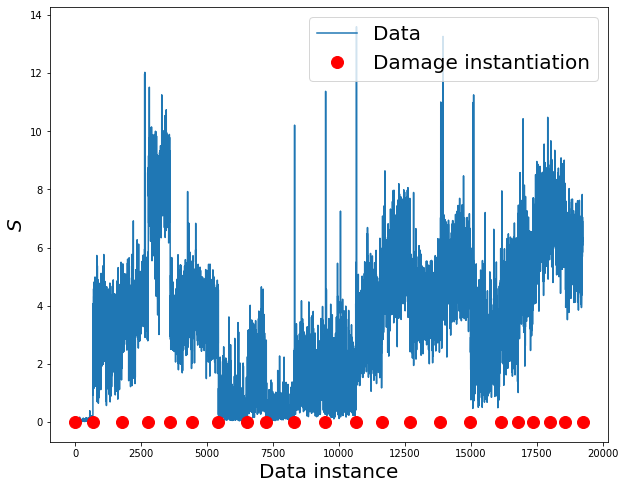

Iter: 1901, D_Loss: 0.1685, G_Loss:1.27


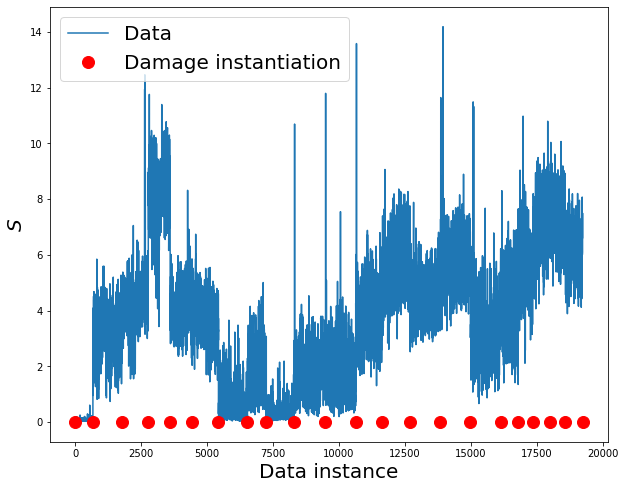

Iter: 1951, D_Loss: 0.1148, G_Loss:1.32


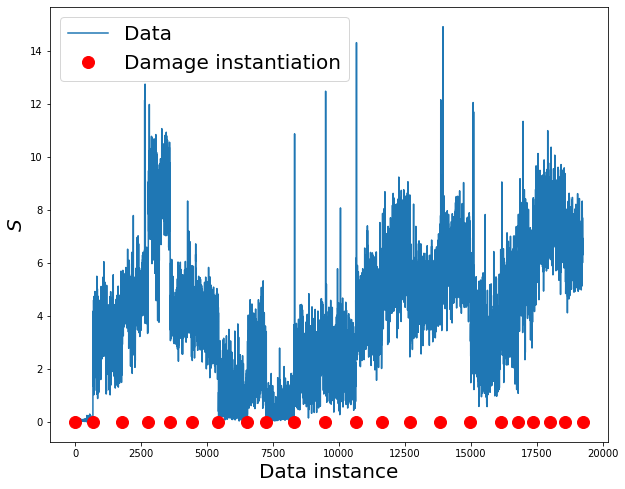

(0.0, 2000.0)

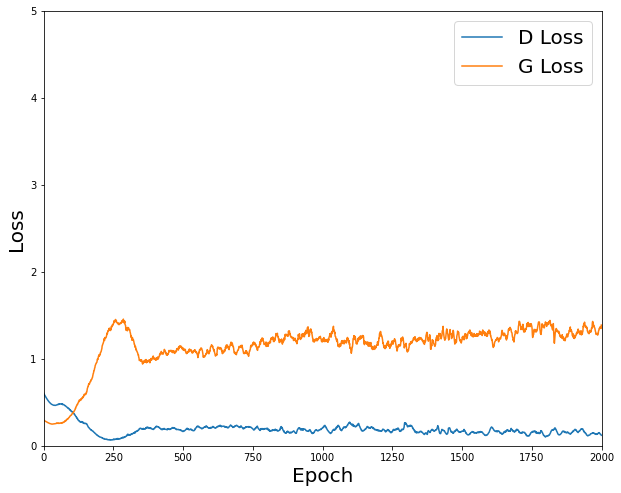

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Epoch=2000;
show_every=50
DM=torch.Tensor(DM).to(device)
## Training on the intact data
H=DM[0:int(E1[1]),:]
H=torch.Tensor(H).to(device)

# Reshapin to the LSTM input shape
H=H.reshape((H.shape[0],1,H.shape[1]))
# D and G 
exec('D=CustomNeuralNetworkS%d().to(device)' %(N))
exec(('G=generator%s(100).to(device)') %(W))


#Adam solvers
D_solver = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))

[G_Loss,D_Loss]=GAN_train(E1,N,W,CL,DM,D, G,D_solver, G_solver, discriminator_loss, generator_loss,train_loader=H, device=device,batch_size=H.shape[0], noise_size=100,num_epochs=Epoch,show_every=show_every)

# Plotting G and D losses at the end
plt.plot(D_Loss)
plt.plot(G_Loss)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend(['D Loss','G Loss'],fontsize=20)
plt.ylim(0,5)
plt.xlim(0,len(D_Loss))


# Save Networks
* You may save your trained network at your iteration of choice (must modify the training function for that) using this command

In [13]:
torch.save({'epoch': 'X','D': D.state_dict()}, os.path.join('/content/checkpoint.pth'))